In [117]:
import os
import kagglehub
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import yeojohnson


In [71]:
sns.set_theme(style='whitegrid', font_scale=.6, palette='Dark2', font='Monospace')

asthetic_constraint=dict(
  alpha=.9
)

In [54]:
path = kagglehub.dataset_download("shivkumarganesh/tinder-google-play-store-review")

os.chdir(path)

data=pd.read_csv(
  os.path.join(path, os.listdir()[0])
)

data.info(1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 641303 entries, 0 to 641302
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   reviewId              641303 non-null  object
 1   userName              641303 non-null  object
 2   userImage             641303 non-null  object
 3   content               639970 non-null  object
 4   score                 641303 non-null  int64 
 5   thumbsUpCount         641303 non-null  int64 
 6   reviewCreatedVersion  509929 non-null  object
 7   at                    641303 non-null  object
 8   replyContent          59332 non-null   object
 9   repliedAt             59332 non-null   object
 10  appVersion            509929 non-null  object
dtypes: int64(2), object(9)
memory usage: 53.8+ MB


In [55]:
data.index.size == data.reviewId.nunique()

True

In [56]:
data=data.iloc[:,[0,3,4,5,7,10]].copy()

In [57]:
data.sample(5)

,reviewId,content,score,thumbsUpCount,at,appVersion
375690,fc4195a7-2dc1-4d97-a9ea-3f7cee52f1f0,good,5,0,2018-09-27 03:48:40,NaN
214454,a516c543-fa42-4d5c-aa41-1e2afb33fd3d,The app isn't bad thou compared to other's.. I...,4,0,2020-11-02 13:50:05,11.27.0
406328,94aec1f8-1add-4a18-a427-28107a5c78f8,nice app,5,0,2018-03-25 15:23:04,NaN
361799,c728af66-4ca0-4edd-809f-be43d72844c5,Cool 😎,5,0,2018-11-17 18:49:17,10.1.0
33998,aa7509c1-63be-42f9-a2a0-ea580ed48429,"Worthless subscription, no one matched after h...",1,0,2024-03-24 16:27:03,15.4.0


In [58]:
data=data.drop('reviewId', axis=1)
data.sample(3)

,content,score,thumbsUpCount,at,appVersion
13228,My account is broken bought 1 month then after...,1,0,2024-09-15 05:21:32,15.16.0
181796,Banned for absolutely no reason.,1,0,2021-05-15 01:58:40,NaN
124010,Fake profiles all over. Nobody to talk to for ...,1,1,2022-06-18 21:53:11,13.10.1


In [59]:
data_processed_some=pd.DataFrame(dict(
  thumb=data.thumbsUpCount,
  star=data.score,
  review=data.content,
  ver=data.appVersion
))
data_processed_some.sample(3)

,thumb,star,review,ver
52997,0,5,waaaooo good app 👌 tinder well,14.20.0
96825,0,2,Solo hay NPCs,13.22.0
334135,0,5,super,NaN


In [60]:
_at=pd.to_datetime(data['at']).round('3h')
_at.to_frame().sample(3)

,at
391292,2018-06-29 12:00:00
559034,2015-09-03 21:00:00
107444,2022-10-12 06:00:00


In [61]:
data_dt=pd.DataFrame(dict(
  at=_at,
  atYear=_at.dt.year,
  atMonth=_at.dt.month,
  atHourInterval=_at.dt.hour,
  atDay=_at.dt.dayofweek
))
data_dt.sample(3)

,at,atYear,atMonth,atHourInterval,atDay
10613,2024-10-07 12:00:00,2024,10,12,0
511791,2016-06-16 18:00:00,2016,6,18,3
96587,2022-12-12 12:00:00,2022,12,12,0


In [62]:
data_processed=pd.concat([
  data_processed_some,
  data_dt
],axis=1).dropna(subset='review').sort_values('atYear')
data_processed.sample(3)

,thumb,star,review,ver,at,atYear,atMonth,atHourInterval,atDay
275900,0,5,Good,11.3.0,2019-11-22 12:00:00,2019,11,12,4
274478,0,5,Dude its tinder,NaN,2019-11-30 18:00:00,2019,11,18,5
487703,1,1,Please fix why the matches are there one secon...,6.4.1,2016-11-16 06:00:00,2016,11,6,2


In [63]:
data_processed.isna().sum()

thumb                  0
star                   0
review                 0
ver               131299
at                     0
atYear                 0
atMonth                0
atHourInterval         0
atDay                  0
dtype: int64

In [64]:
_ver_interp=pd.DataFrame(
  dict(
    ind=data_processed.index,
    ver=data_processed.ver.to_list()
  ),
  index=data_processed['at']
)
_ver_interp.ver[data_processed.ver.isna().to_list()]

at
2013-11-06 18:00:00    NaN
2013-11-05 15:00:00    NaN
2013-11-05 15:00:00    NaN
2013-11-07 15:00:00    NaN
2013-11-07 00:00:00    NaN
                      ... 
2025-01-04 12:00:00    NaN
2025-01-04 00:00:00    NaN
2025-01-04 00:00:00    NaN
2025-01-04 03:00:00    NaN
2025-01-04 03:00:00    NaN
Name: ver, Length: 131299, dtype: object

In [65]:
_ver_interp.interpolate('pad')[data_processed.ver.isna().to_list()]

,ind,ver
at,,
2013-11-06 18:00:00,635911,1.5.6
2013-11-05 15:00:00,636008,1.5.6
2013-11-05 15:00:00,635999,1.5.6
2013-11-07 15:00:00,635832,1.5.6
2013-11-07 00:00:00,635884,1.5.6
...,...,...
2025-01-04 12:00:00,662,15.23.0
2025-01-04 00:00:00,720,15.23.0
2025-01-04 00:00:00,719,15.23.0


In [66]:
_ver_interp=_ver_interp.interpolate('pad')
data_processed.loc[:, 'ver']=_ver_interp.ver.to_list()
data_processed.ver.isna().sum()

0

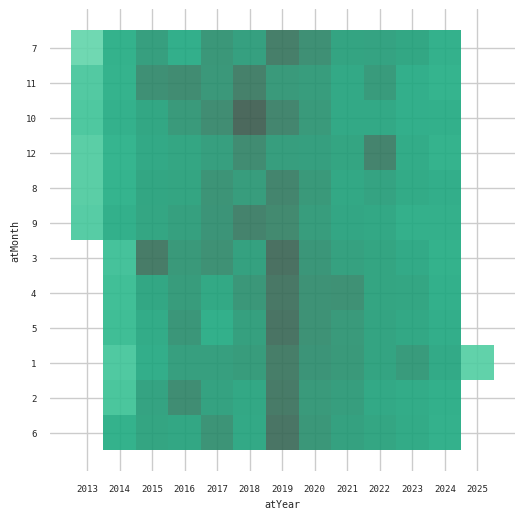

In [67]:
plt.subplots(figsize=(6,6))
sns.histplot(data_processed, x=data_processed.atYear.astype('str'), y=data_processed.atMonth.astype('str'), stat='count', **asthetic_constraint)
sns.despine(left=True,right=True,top=True,bottom=True)

<Axes: xlabel='count', ylabel='atYear'>

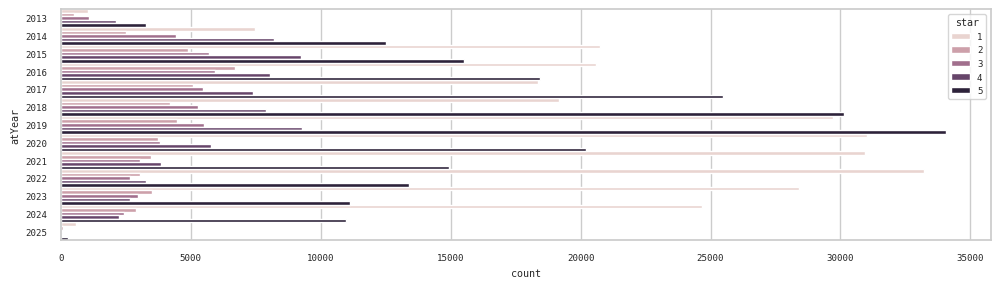

In [ ]:
plt.subplots(figsize=(12,3))
sns.countplot(data_processed, y='atYear', hue='star',
  dodge=True, width=1.)

In [81]:
data_processed.loc[:, 'ver'] = data_processed.ver.apply(
  lambda q: q[:q.index('.')] if q.__contains__('.') else q
)
data_processed.sample(3)

,thumb,star,review,ver,at,atYear,atMonth,atHourInterval,atDay
527753,0,2,It was good before but now there are too many ...,4,2016-03-14 00:00:00,2016,3,0,0
551995,0,5,Only wish u got more likes for free,4,2015-10-22 12:00:00,2015,10,12,3
549580,0,3,Fun app but crashes and won't allow to swipe o...,4,2015-11-09 18:00:00,2015,11,18,0


[Text(0.5, 0, 'Year')]

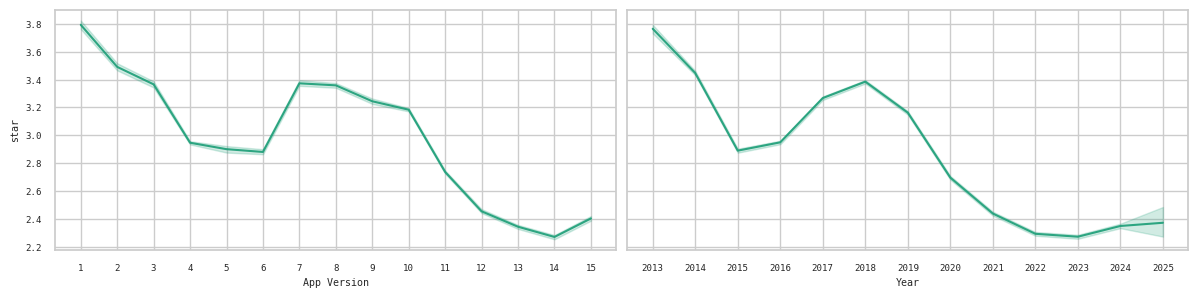

In [106]:
fig,ax=plt.subplots(1,2,figsize=(12,3),layout='tight',sharey=True)

star_by_ver=sns.lineplot(data_processed, x='ver', y='star', n_boot=300,
  ax=ax[0], **asthetic_constraint)


star_by_year=sns.lineplot(data_processed, x=data_processed.atYear.astype('str'), y='star', n_boot=300,
  ax=ax[1], **asthetic_constraint)

star_by_ver.set(xlabel='App Version')
star_by_year.set(xlabel='Year')

In [122]:
data_processed=data_processed.assign(score=\
  yeojohnson((data_processed.thumb + 1) * (data_processed.star - 2.5))[0]
)
data_processed.sample(3)

,thumb,star,review,ver,at,atYear,atMonth,atHourInterval,atDay,score
318794,0,1,horrible,10,2019-05-14 00:00:00,2019,5,0,1,-1.456248
449106,0,5,Islam also7do Ishmael rapidly Sindhi symbiosis...,7,2017-07-19 03:00:00,2017,7,3,2,2.609002
571014,0,4,But takes time to load and operate,4,2015-06-14 09:00:00,2015,6,9,6,1.545396


In [128]:
data_processed.reset_index(drop=True).to_feather('~/res/_gps-review-scrap.feather',
  compression='zstd',
  compression_level=9
)